In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
pd.options.display.float_format = '{:.2f}'.format
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve

# Data Exploration

In [2]:
train = pd.read_csv('fraudTrain.csv')
test = pd.read_csv('fraudTest.csv')
data_original=pd.concat([train, test], ignore_index=True)
data = data_original

In [3]:
data.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [5]:
# Assuming 'trans_date_trans_time' is the name of the object column containing date and time
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], format='%Y-%m-%d')
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_quater'] = data['trans_date_trans_time'].dt.quarter

In [6]:
data.tail(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_month,trans_year,trans_quater
1852392,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.47,-117.08,0,12,2020,4
1852393,555718,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,...,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.21,-97.04,0,12,2020,4


In [7]:
data['dob'] = pd.to_datetime(data['dob'])

# Calculate age by subtracting DOB from the transaction date and extracting years
data['Cust_age'] = (data['trans_date_trans_time'] - data['dob']).dt.days // 365


In [8]:
data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'trans_month', 'trans_year',
       'trans_quater', 'Cust_age'],
      dtype='object')

In [9]:
data = data.drop(labels = ['Unnamed: 0', 'first', 'last', 'street', 'city', 'state', 'zip',
                           'dob', 'trans_num', 'unix_time'], axis =1)

In [10]:
data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,trans_month,trans_year,trans_quater,Cust_age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.08,-81.18,3495,"Psychologist, counselling",36.01,-82.05,0,1,2019,1,30
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.89,-118.21,149,Special educational needs teacher,49.16,-118.19,0,1,2019,1,40


# Data Cleaning

In [11]:
# Checking the data if we have missing values in the dataset
data_missing = pd.DataFrame(
    100 * data.isnull().sum() / data.shape[0],
    columns=["Missing Values Percentage"],
)

# Filtering out the variables which have missing values in it.
data_missing

,Missing Values Percentage
trans_date_trans_time,0.00
cc_num,0.00
merchant,0.00
category,0.00
amt,0.00
gender,0.00
lat,0.00
long,0.00
city_pop,0.00
job,0.00


* Looks like we don't have any Missing values in the dataset

In [12]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'trans_month', 'trans_year', 'trans_quater', 'Cust_age'],
      dtype='object')

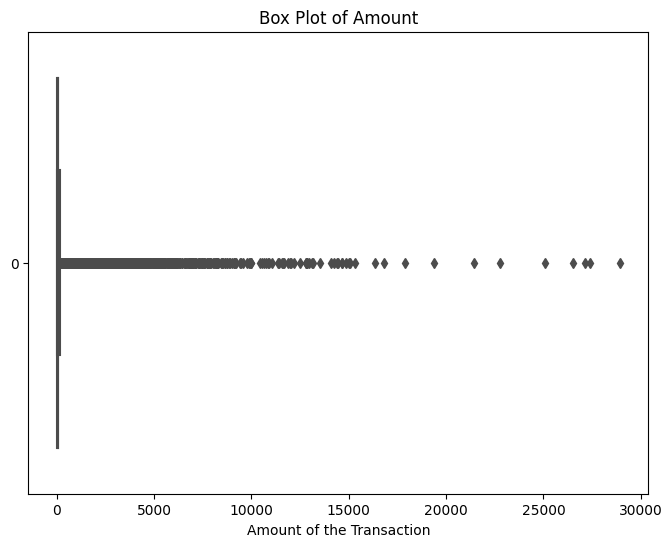

In [13]:
# Create a box plot for visualising the Outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=data['amt'], orient="h", palette="Set1")
plt.title("Box Plot of Amount")
plt.xlabel("Amount of the Transaction")

plt.show()

* Even though Amount has outliers in it, We are going to treat them as genuine outliers, It can help us in determining fraud tranactions if the amount is too high and unauthorized. In model building we can use models which are robust towards outliers like XGBoost or RandomForest Classifier models.

In [14]:
# Dropping the duplicates 
data = data.drop_duplicates(keep='last')

In [15]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'trans_month', 'trans_year', 'trans_quater', 'Cust_age'],
      dtype='object')

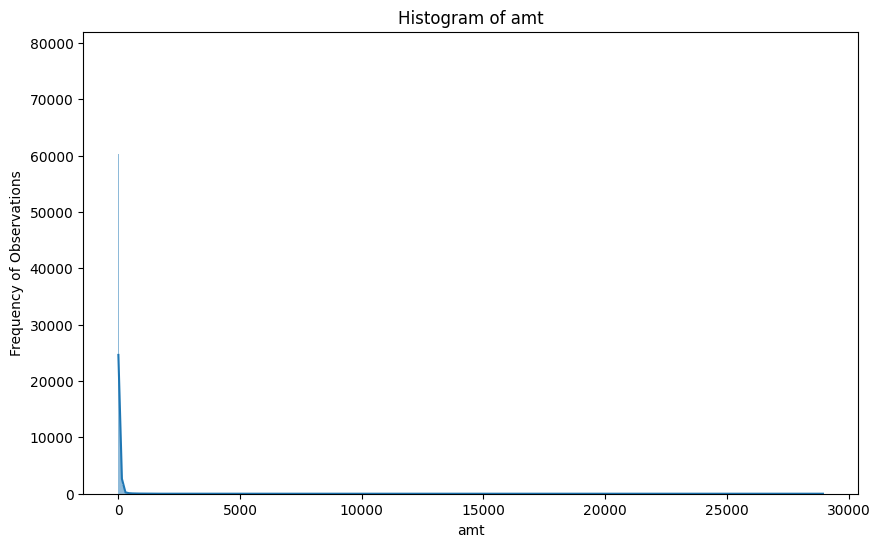

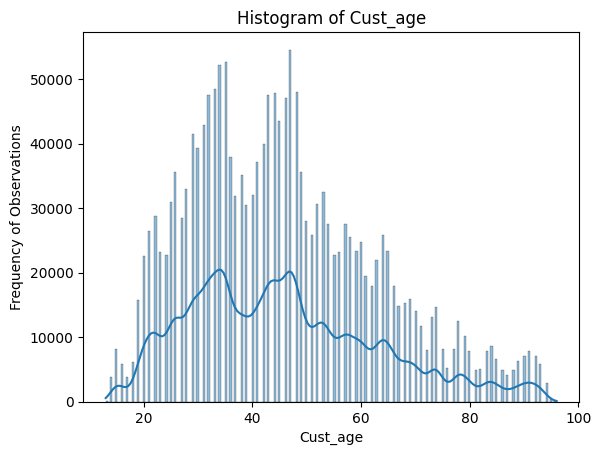

In [16]:
# Selecting Numerical Variables to visualize the data distribution
col = ['amt','Cust_age']

# Setting up the figure size
plt.figure(figsize=(10, 6))

# Plotting histograms to show the data distribution of nuerical variables
# Bascially iterating each variable and plotting the distribution
for var in col:
    sns.histplot(data=data, x=var, kde=True)
    plt.xlabel(var)
    plt.ylabel('Frequency of Observations')
    plt.title(f'Histogram of {var}')
    plt.show()


* Observations: 
    * Looks like Amount is left skewed, due to the presence of high amount transactions
    * Age Distribution is normally distributed

In [17]:
data['amt'].describe()

count   1852394.00
mean         70.06
std         159.25
min           1.00
25%           9.64
50%          47.45
75%          83.10
max       28948.90
Name: amt, dtype: float64

# Feature Engineering

**Geographic Features**

* **distance_customer_merchant**: Feature that store the calculated distance between Merchant location to the actual location

In [18]:
# To calculate the distance we have external library geopy which has Haversine distance formula
from geopy.distance import geodesic

data['distance_customer_merchant'] = data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).kilometers, axis=1)


In [19]:
data['distance_customer_merchant'].describe()

count   1852394.00
mean         76.11
std          29.09
min           0.02
25%          55.34
50%          78.25
75%          98.47
max         151.87
Name: distance_customer_merchant, dtype: float64

* **city_pop_category**: Binning the city population into three groups - Rural, Sub-Urban, and Urban regions

In [20]:
data['city_pop'].describe()

count   1852394.00
mean      88643.67
std      301487.62
min          23.00
25%         741.00
50%        2443.00
75%       20328.00
max     2906700.00
Name: city_pop, dtype: float64

In [21]:
# Creating bins based on the city population distribution
bins = [0, 5000, 50000, float('inf')]
labels = ['rural', 'sub-urban', 'urban']

data['city_pop_category'] = pd.cut(data['city_pop'], bins=bins, labels=labels)

# Print the value counts of each category
data['city_pop_category'].value_counts()

city_pop_category
rural        1128500
sub-urban     377703
urban         346191
Name: count, dtype: int64

* **avg_amount_by_category**: Average amount per each transaction category

In [22]:
# Calculating average transaction amount for each category
avg_amount_by_category = data.groupby('category')['amt'].mean()

# Mapping the average amounts back to the original DataFrame
data['avg_amount_by_category'] = data['category'].map(avg_amount_by_category)

* **Age_Category**

In [23]:
data['Cust_age'].describe()

count   1852394.00
mean         45.80
std          17.42
min          13.00
25%          32.00
50%          44.00
75%          57.00
max          96.00
Name: Cust_age, dtype: float64

In [24]:
# Creating bins for age groups
bins = [0, 18, 35, 50, 65, float('inf')]
categories = ['Teen', 'Young Adult', 'Mid-Age', 'Senior', 'Elderly']

# Add a new column 'age_group' based on 'Cust_age' and the defined bins and categories
data['age_group'] = pd.cut(data['Cust_age'], bins=bins, labels=categories, right=False).astype('category')

data['age_group'].value_counts()

age_group
Mid-Age        621615
Young Adult    546048
Senior         377014
Elderly        285917
Teen            21800
Name: count, dtype: int64

**time_since_previous_transaction**

In [25]:
data['trans_date_trans_time'] = data_original['trans_date_trans_time']

In [26]:

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data = data.sort_values(by=['cc_num', 'trans_date_trans_time'])  # Sort by credit card and transaction time

data['time_since_previous_transaction'] = data.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds()/ (60 * 60 * 24)

# Fill missing values with a reasonable default (e.g., 0 for the first transaction of each credit card)
data['time_since_previous_transaction'].fillna(0, inplace=True)


In [27]:
data.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,gender,lat,long,city_pop,job,...,is_fraud,trans_month,trans_year,trans_quater,Cust_age,distance_customer_merchant,city_pop_category,avg_amount_by_category,age_group,time_since_previous_transaction
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27,F,43.00,-108.90,1645,Information systems manager,...,0,1,2019,1,32,127.63,rural,80.18,Young Adult,0.00
2724,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94,F,43.00,-108.90,1645,Information systems manager,...,0,1,2019,1,32,110.20,rural,63.48,Young Adult,0.83
2726,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08,F,43.00,-108.90,1645,Information systems manager,...,0,1,2019,1,32,21.84,rural,63.48,Young Adult,0.00
2882,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79,F,43.00,-108.90,1645,Information systems manager,...,0,1,2019,1,32,87.12,rural,57.53,Young Adult,0.16
2907,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18,F,43.00,-108.90,1645,Information systems manager,...,0,1,2019,1,32,74.35,rural,58.19,Young Adult,0.02


In [28]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'gender', 'lat', 'long', 'city_pop', 'job', 'merch_lat', 'merch_long',
       'is_fraud', 'trans_month', 'trans_year', 'trans_quater', 'Cust_age',
       'distance_customer_merchant', 'city_pop_category',
       'avg_amount_by_category', 'age_group',
       'time_since_previous_transaction'],
      dtype='object')

In [29]:
fraud_data = data[data['is_fraud'] == 1]

In [30]:
fraud_data.shape

(9651, 22)

# Exploratory Data Analysis

* **Transaction Patterns**

In [31]:
import plotly.express as px

# Histogram of transaction amounts for fraud transactions
fig1 = px.histogram(fraud_data, x='amt', nbins=50, marginal='box', title="Transaction Amount Distribution (Fraud)")
fig1.update_layout(xaxis_title="Transaction Amount", yaxis_title="Frequency")
fig1.show()


# Feature Scaling

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1017 to 1850558
Data columns (total 22 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   trans_date_trans_time            datetime64[ns]
 1   cc_num                           int64         
 2   merchant                         object        
 3   category                         object        
 4   amt                              float64       
 5   gender                           object        
 6   lat                              float64       
 7   long                             float64       
 8   city_pop                         int64         
 9   job                              object        
 10  merch_lat                        float64       
 11  merch_long                       float64       
 12  is_fraud                         int64         
 13  trans_month                      int32         
 14  trans_year                       int

In [33]:
data = data.drop(labels=['lat', 'long', 'merch_lat', 'merch_long', 'cc_num','city_pop', 'trans_date_trans_time', 'merchant', 'job'], axis = 1)

In [34]:
data.head(2)

,category,amt,gender,is_fraud,trans_month,trans_year,trans_quater,Cust_age,distance_customer_merchant,city_pop_category,avg_amount_by_category,age_group,time_since_previous_transaction
1017,misc_net,7.27,F,0,1,2019,1,32,127.63,rural,80.18,Young Adult,0.00
2724,gas_transport,52.94,F,0,1,2019,1,32,110.20,rural,63.48,Young Adult,0.83


In [35]:
#  LOB and Gender
from sklearn.preprocessing import LabelEncoder
data = pd.get_dummies(data = data, columns=['gender','trans_year'], dtype=int)

# Policy Type and Marital Status
encoder_ex = LabelEncoder()
data['category'] = encoder_ex.fit_transform(data['category'])
data['city_pop_category'] = encoder_ex.fit_transform(data['city_pop_category'])
data['age_group'] = encoder_ex.fit_transform(data['age_group'])

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 1017 to 1850558
Data columns (total 15 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   category                         int32  
 1   amt                              float64
 2   is_fraud                         int64  
 3   trans_month                      int32  
 4   trans_quater                     int32  
 5   Cust_age                         int64  
 6   distance_customer_merchant       float64
 7   city_pop_category                int32  
 8   avg_amount_by_category           float64
 9   age_group                        int32  
 10  time_since_previous_transaction  float64
 11  gender_F                         int32  
 12  gender_M                         int32  
 13  trans_year_2019                  int32  
 14  trans_year_2020                  int32  
dtypes: float64(4), int32(9), int64(2)
memory usage: 162.5 MB


In [37]:

# Assuming 'data' is your DataFrame and you want to scale specific columns
columns_to_scale = ['amt', 'Cust_age', 'distance_customer_merchant', 'avg_amount_by_category','time_since_previous_transaction']

# Create a copy of the DataFrame
data_scaled = data.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Standard scale the selected columns
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])


In [38]:
data_scaled.head(2)

,category,amt,is_fraud,trans_month,trans_quater,Cust_age,distance_customer_merchant,city_pop_category,avg_amount_by_category,age_group,time_since_previous_transaction,gender_F,gender_M,trans_year_2019,trans_year_2020
1017,8,-0.39,0,1,1,-0.79,1.77,0,0.50,4,-0.68,1,0,1,0
2724,2,-0.11,0,1,1,-0.79,1.17,0,-0.32,4,0.90,1,0,1,0


In [39]:
# Splitting the data into training and testing sets

X = data_scaled.drop('is_fraud', axis=1)
y = data_scaled['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='is_fraud', ylabel='count'>

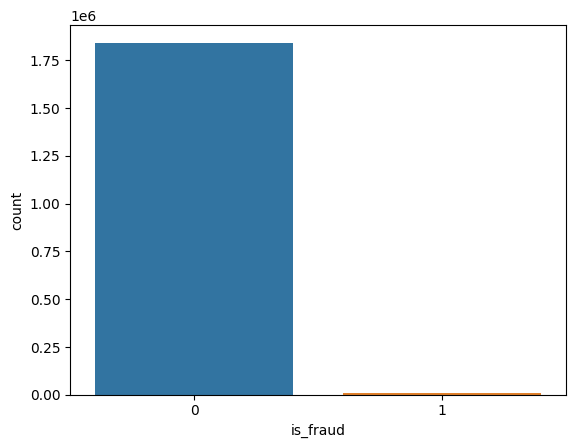

In [40]:
sns.countplot(x = 'is_fraud', data = data)

In [41]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [42]:
# Train an XGBoost classifier with hyperparameters
xgb_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model's performance on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

Test Set Performance:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    368595
           1       0.16      0.90      0.26      1884

    accuracy                           0.97    370479
   macro avg       0.58      0.94      0.63    370479
weighted avg       1.00      0.97      0.98    370479



Random Forest:
Accuracy: 97.45626607715957
Precision: 99.51864945716112
Recall: 97.45626607715957


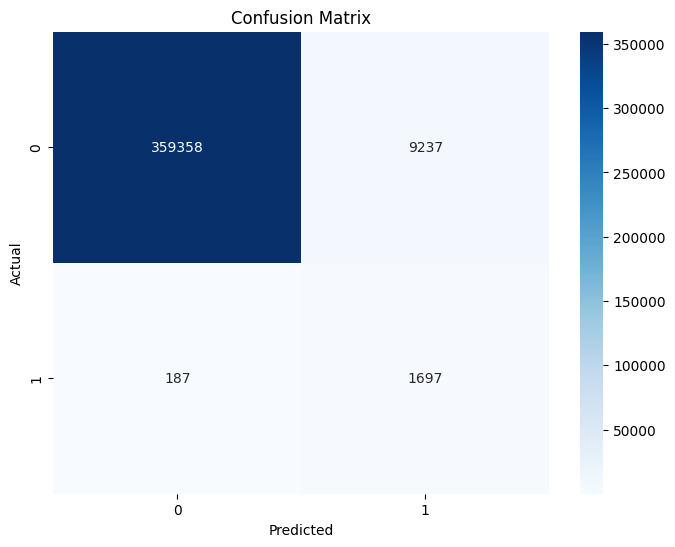

In [43]:
# Evaluating the models by defining the model metrics function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Accuracy:", accuracy*100)
    print("Precision:", precision*100)
    print("Recall:", recall*100)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("Random Forest:")
evaluate_model(y_test, y_pred)


In [44]:
importance_scores = xgb_clf.feature_importances_

# Creating a DataFrame to store feature importances along with their names
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

# Sorting the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#  Accessing the Most contributing features
print("Top contributing features:")
print(importance_df.head(30))  

Top contributing features:
                            Feature  Importance
1                               amt        0.31
12                  trans_year_2019        0.16
7            avg_amount_by_category        0.12
10                         gender_F        0.09
0                          category        0.07
9   time_since_previous_transaction        0.06
11                         gender_M        0.05
2                       trans_month        0.04
6                 city_pop_category        0.03
3                      trans_quater        0.03
13                  trans_year_2020        0.02
4                          Cust_age        0.02
5        distance_customer_merchant        0.01
8                         age_group        0.00


AUC-ROC Score of Random Forest Model: 0.9881392895539034


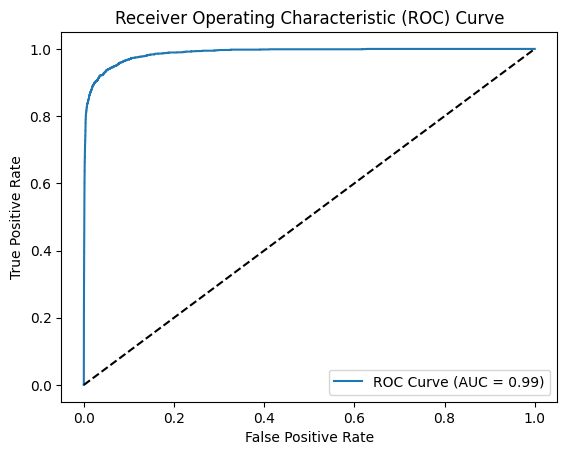

In [45]:
# Predicting probabilities for the test set
y_pred_proba_RF = xgb_clf.predict_proba(X_test)[:, 1]

# Calculating the AUC-ROC score
auc_roc_score = roc_auc_score(y_test, y_pred_proba_RF)
print("AUC-ROC Score of Random Forest Model:", auc_roc_score)

# ROC curve plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_roc_score))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
